# Prevendo a nota final dos alunos da Escola Todos Unidos

In [ ]:
pip install yellowbrick

In [2]:
#Importações de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Importação de funções das bibliotecas
from matplotlib.font_manager import FontProperties
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score
from yellowbrick.model_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

In [5]:
df_notas = pd.read_csv('student-mat.csv')
df_notas.shape

(395, 33)

In [6]:
#Verificação de dados faltantes
def missing_values_table(df):
        mis_val = df.isnull().sum() # conta a quantidade de missing
        mis_val_percent = 100 * df.isnull().sum() / len(df) # calcula a porcentagem
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) # cria uma tabela
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valores faltantes', 1 : '% do total'}) # renomeia as colunas
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% do total', ascending=False).round(1) # ordena os valores
        print ("Você selecionou um dataframe que tem " + str(df.shape[1]) + " colunas.\n"      
            "E há " + str(mis_val_table_ren_columns.shape[0]) +
              " colunas com valores faltantes")
        return mis_val_table_ren_columns

In [4]:
missing_df = missing_values_table(df_notas)
missing_df.tail()

Você selecionou um dataframe que tem 33 colunas.
E há 0 colunas com valores faltantes


,Valores faltantes,% do total


## Preparação da planilha

### TRATANDO DADOS CATEGÓRICOS: Transformar variáveis categóricas em numéricas
Para análise comparativa das variáveis, precisamos que todas fiquem numéricas

In [7]:
#categorias com strings
categoricas = ['school',\
               'sex',\
              'address',\
              'famsize',\
               'Pstatus',\
               'Mjob',\
               'Fjob',\
               'reason',\
               'guardian',\
               'schoolsup',\
               'famsup',\
               'paid',\
               'activities',\
               'nursery',\
               'higher',\
               'internet',\
               'romantic',
                ]

In [8]:
# Escolher o melhor método (um ficará comentado)
le = LabelEncoder()
# apply le on categorical feature columns
df_notas[categoricas] = df_notas[categoricas].apply(lambda col: le.fit_transform(col))
df_notas[categoricas].head( )

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,0,0,1,0,0,0,4,0,1,1,0,0,0,1,1,0,0
1,0,0,1,0,1,0,2,0,0,0,1,0,0,0,1,1,0
2,0,0,1,1,1,0,2,2,1,1,0,1,0,1,1,1,0
3,0,0,1,0,1,1,3,1,1,0,1,1,1,1,1,1,1
4,0,0,1,0,1,2,2,1,0,0,1,1,0,1,1,0,0


In [ ]:
#oe = OrdinalEncoder()
#categorical = df_notas[categoricas]
#oe.fit(categorical)
#numerical = oe.transform(categorical)

#for n, feat in enumerate(categoricas):
#    df_notas[feat] = numerical[:, n]
#df_notas.head( )

### Normalização dos dados
A normalização dos dados coloca-os na mesma ordem de grandeza

In [9]:
#Este processo PADRONIZA as variáveis
escala = StandardScaler().fit(df_notas)
df_notasN = escala.transform(df_notas)
df_notas = pd.DataFrame(StandardScaler().fit_transform(df_notasN), columns=df_notas.columns, index=df_notas.index)
df_notas.head( )

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,-0.36305,-0.948176,1.023046,0.535392,-0.636941,-2.938392,1.143856,1.360371,-1.769793,1.993149,...,0.062194,-0.236010,0.801479,-0.540699,-1.003789,-0.399289,0.036424,-1.782467,-1.254791,-0.964934
1,-0.36305,-0.948176,0.238380,0.535392,-0.636941,0.340322,-1.600009,-1.399970,-1.769793,-0.325831,...,1.178860,-0.236010,-0.097908,-0.540699,-1.003789,-0.399289,-0.213796,-1.782467,-1.520979,-0.964934
2,-0.36305,-0.948176,-1.330954,0.535392,1.570004,0.340322,-1.600009,-1.399970,-1.769793,-0.325831,...,0.062194,-0.236010,-0.997295,0.583385,0.551100,-0.399289,0.536865,-1.179147,-0.722415,-0.090739
3,-0.36305,-0.948176,-1.330954,0.535392,-0.636941,0.340322,1.143856,-0.479857,-0.954077,0.833659,...,-1.054472,-1.238419,-0.997295,-0.540699,-1.003789,1.041070,-0.464016,1.234133,0.874715,1.002004
4,-0.36305,-0.948176,-0.546287,0.535392,-0.636941,0.340322,0.229234,0.440257,-0.138362,-0.325831,...,0.062194,-0.236010,-0.997295,-0.540699,-0.226345,1.041070,-0.213796,-1.480807,-0.190038,-0.090739


In [ ]:
#Este processo NORMALIZA as variáveis - ESCOLHER APENAS UM PROCESSO
#escala = Normalizer().fit(df_notas)
#df_notasN = escala.transform(df_notas)
#df_notas = pd.DataFrame(Normalizer().fit_transform(df_notasN), columns=df_notas.columns, index=df_notas.index)

### Construindo gráficos de demonstração de importância das variáveis

In [26]:
X = df_notas.drop('G3', axis=1)
y = df_notas['G3']
print(X.shape)
print(y.shape)

(395, 32)
(395,)


## Dados preparados para escolha do tipo de algoritmo
O algoritmo escolhido após vários testes foi o ELastic Net

### Gráficos Yellowbrick

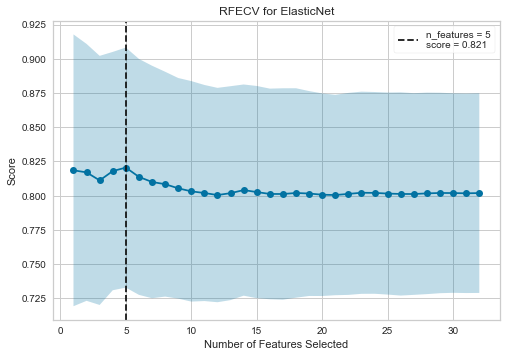

<AxesSubplot:title={'center':'RFECV for ElasticNet'}, xlabel='Number of Features Selected', ylabel='Score'>

In [16]:
#Gera um gráfico com a melhor quantidade de variáveis a ser considerada e quais são elas
visualizer = RFECV(ElasticNet(alpha=0.0001,l1_ratio=0.1), cv=8, scoring='r2')
visualizer.fit(X, y)
visualizer.show()

In [17]:
X.loc[:, X.columns != 'IN_TREINEIRO'].columns[visualizer.support_] #colunas que ele retornou como importante

Index(['age', 'famrel', 'absences', 'G1', 'G2'], dtype='object')

### Depois de aplicar o Yellowbrick

In [39]:
#Cria planilha nova APENAS COM as features que o Yellowbrick considerou IMPORTANTES (drop nas demais)
df_notas3 = df_notas.loc[:, ['age', 'famrel', 'absences', 'G1', 'G2']]

### Plot comparativo de variáveis indicadas no Yellowbrick + 3 escolhidas aleatoriamente

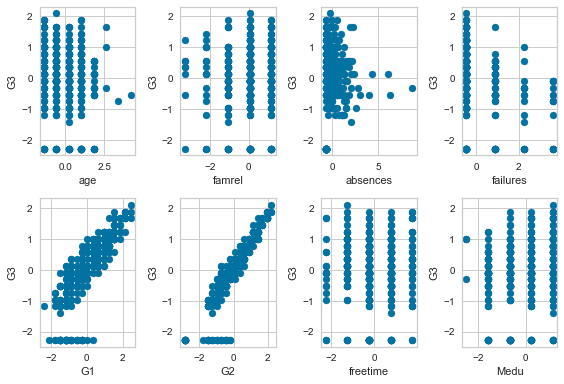

In [27]:
# Cria gráficos que demonstram as posições dos dados usando as variáveis indicadas no Yellowbrick, em uma matriz (2,4)
fig, ax = plt.subplots(2, 4)
ax[0,0].scatter(X.iloc[:,2],y);
ax[0,0].set_xlabel('age');
ax[0,0].set_ylabel('G3');

ax[0,1].scatter(X.iloc[:,23],y);
ax[0,1].set_xlabel('famrel');
ax[0,1].set_ylabel('G3');

ax[0,2].scatter(X.iloc[:,29],y);
ax[0,2].set_xlabel('absences');
ax[0,2].set_ylabel('G3');

ax[0,3].scatter(X.iloc[:,14],y);
ax[0,3].set_xlabel('failures');
ax[0,3].set_ylabel('G3');

ax[1,0].scatter(X.iloc[:,30],y);
ax[1,0].set_xlabel('G1');
ax[1,0].set_ylabel('G3');

ax[1,1].scatter(X.iloc[:,31],y);
ax[1,1].set_xlabel('G2');
ax[1,1].set_ylabel('G3');

ax[1,2].scatter(X.iloc[:,24],y);
ax[1,2].set_xlabel('freetime');
ax[1,2].set_ylabel('G3');

ax[1,3].scatter(X.iloc[:,6],y);
ax[1,3].set_xlabel('Medu');
ax[1,3].set_ylabel('G3');

plt.tight_layout();

# Regressor ElasticNet
De acordo com https://medium.com/turing-talks/turing-talks-20-regressão-de-ridge-e-lasso-a0fc467b5629 esse método pode ser melhor para o tipo de problema sugerido

### Teste com planilha completa

In [28]:
#X = df_notas.drop('G3', axis=1)
#y = df_notas['G3']
#X = df_notas3

#Divide as variáveis em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = [0.0001,0.001, 0.01, 0.1, 0.5, 1]
l1s = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
score = []

In [14]:
#Teste com diferentes alphas e l1_ratio
for i in range(len(alphas)):
    for j in range(len(l1s)):
        teste_EN = ElasticNet(alpha=alphas[i],l1_ratio=l1s[j])
        teste_EN.fit(X_train, y_train)
        score = teste_EN.score(X_train, y_train)
        print("alpha = ",alphas[i]," l1_ratio = ",l1s[j]," Score = ",score)

alpha =  0.0001  l1_ratio =  0.1  Score =  0.8606895672202296
alpha =  0.0001  l1_ratio =  0.2  Score =  0.8606895548806817
alpha =  0.0001  l1_ratio =  0.3  Score =  0.8606895334120126
alpha =  0.0001  l1_ratio =  0.4  Score =  0.8606895027638097
alpha =  0.0001  l1_ratio =  0.5  Score =  0.8606894631438942
alpha =  0.0001  l1_ratio =  0.6  Score =  0.8606894148415771
alpha =  0.0001  l1_ratio =  0.7  Score =  0.8606893562231206
alpha =  0.0001  l1_ratio =  0.8  Score =  0.860689290654955
alpha =  0.0001  l1_ratio =  0.9  Score =  0.860689213451511
alpha =  0.001  l1_ratio =  0.1  Score =  0.8606876290498802
alpha =  0.001  l1_ratio =  0.2  Score =  0.8606863933961443
alpha =  0.001  l1_ratio =  0.3  Score =  0.8606842476407408
alpha =  0.001  l1_ratio =  0.4  Score =  0.8606811439964501
alpha =  0.001  l1_ratio =  0.5  Score =  0.8606770809665173
alpha =  0.001  l1_ratio =  0.6  Score =  0.8606720570496726
alpha =  0.001  l1_ratio =  0.7  Score =  0.8606660707405904
alpha =  0.001  l

### Aplicando o regressor

In [36]:
# Usando os dados da linha anterior, o melhor score
notas_completa = ElasticNet(alpha=0.0001,l1_ratio=0.1)
notas_completa.fit(X_train, y_train)

ElasticNet(alpha=0.0001, l1_ratio=0.1)

In [37]:
y_pred = notas_completa.predict(X_test)

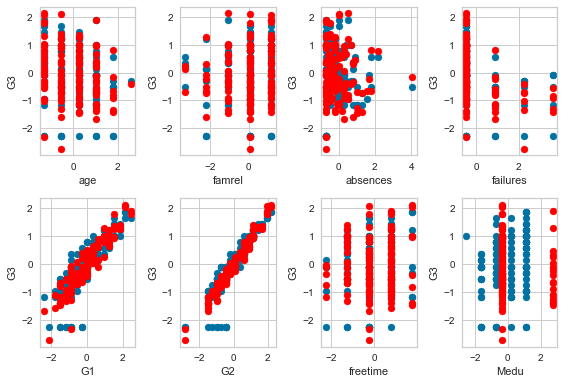

In [34]:
# Cria gráficos que demonstram as posições dos dados usando as variáveis indicadas no Yellowbrick, em uma matriz (3,3)
fig, ax = plt.subplots(2, 4)
ax[0,0].scatter(X_test.iloc[:,2],y_test);
ax[0,0].scatter(X_test.iloc[:,2],y_pred,color='red');
ax[0,0].set_xlabel('age');
ax[0,0].set_ylabel('G3');

ax[0,1].scatter(X_test.iloc[:,23],y_test);
ax[0,1].scatter(X_test.iloc[:,23],y_pred,color='red');
ax[0,1].set_xlabel('famrel');
ax[0,1].set_ylabel('G3');

ax[0,2].scatter(X_test.iloc[:,29],y_test);
ax[0,2].scatter(X_test.iloc[:,29],y_pred,color='red');
ax[0,2].set_xlabel('absences');
ax[0,2].set_ylabel('G3');

ax[0,3].scatter(X_test.iloc[:,14],y_test);
ax[0,3].scatter(X_test.iloc[:,14],y_pred,color='red');
ax[0,3].set_xlabel('failures');
ax[0,3].set_ylabel('G3');

ax[1,0].scatter(X_test.iloc[:,30],y_test);
ax[1,0].scatter(X_test.iloc[:,30],y_pred,color='red');
ax[1,0].set_xlabel('G1');
ax[1,0].set_ylabel('G3');

ax[1,1].scatter(X_test.iloc[:,31],y_test);
ax[1,1].scatter(X_test.iloc[:,31],y_pred,color='red');
ax[1,1].set_xlabel('G2');
ax[1,1].set_ylabel('G3');

ax[1,2].scatter(X_test.iloc[:,24],y_test);
ax[1,2].scatter(X_test.iloc[:,24],y_pred,color='red');
ax[1,2].set_xlabel('freetime');
ax[1,2].set_ylabel('G3');

ax[1,3].scatter(X_test.iloc[:,6],y_test);
ax[1,3].scatter(X_test.iloc[:,0],y_pred,color='red');
ax[1,3].set_xlabel('Medu');
ax[1,3].set_ylabel('G3');

plt.tight_layout();

In [38]:
#avaliação da qualidade do modelo
score = notas_completa.score(X_test, y_test)
print('Score:', score)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) #próx de 0, melhor
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #medida de dispersão

Score: 0.7947778147438245
Mean Absolute Error: 0.3058650060022317
Mean Squared Error: 0.21547115338548534
Root Mean Squared Error: 0.4641887045001045


## Teste apenas com as colunas marcadas como importantes no Yellowbrick

In [40]:
#X = df_notas.drop('G3', axis=1)
y = df_notas['G3']
X = df_notas3

#Divide as variáveis em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = [0.0001,0.001, 0.01, 0.1, 0.5, 1]
l1s = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
score = []

In [41]:
#Teste com diferentes alphas e l1_ratio
for i in range(len(alphas)):
    for j in range(len(l1s)):
        teste_EN = ElasticNet(alpha=alphas[i],l1_ratio=l1s[j])
        teste_EN.fit(X_train, y_train)
        score = teste_EN.score(X_train, y_train)
        print("alpha = ",alphas[i]," l1_ratio = ",l1s[j]," Score = ",score)

alpha =  0.0001  l1_ratio =  0.1  Score =  0.8442442216565335
alpha =  0.0001  l1_ratio =  0.2  Score =  0.8442442161930637
alpha =  0.0001  l1_ratio =  0.3  Score =  0.8442442107470385
alpha =  0.0001  l1_ratio =  0.4  Score =  0.8442442118295466
alpha =  0.0001  l1_ratio =  0.5  Score =  0.8442442118839123
alpha =  0.0001  l1_ratio =  0.6  Score =  0.8442442109099565
alpha =  0.0001  l1_ratio =  0.7  Score =  0.8442442089075003
alpha =  0.0001  l1_ratio =  0.8  Score =  0.8442442058763645
alpha =  0.0001  l1_ratio =  0.9  Score =  0.8442442018163698
alpha =  0.001  l1_ratio =  0.1  Score =  0.8442427043689805
alpha =  0.001  l1_ratio =  0.2  Score =  0.8442427776963102
alpha =  0.001  l1_ratio =  0.3  Score =  0.844242749090842
alpha =  0.001  l1_ratio =  0.4  Score =  0.844242618376574
alpha =  0.001  l1_ratio =  0.5  Score =  0.8442423853769985
alpha =  0.001  l1_ratio =  0.6  Score =  0.8442420499150999
alpha =  0.001  l1_ratio =  0.7  Score =  0.8442416118133531
alpha =  0.001  l

In [45]:
# Usando os dados da linha anterior, o melhor score
notas_parcial = ElasticNet(alpha=0.0001,l1_ratio=0.1)
notas_parcial.fit(X_train, y_train)

ElasticNet(alpha=0.0001, l1_ratio=0.1)

In [47]:
y_pred = notas_parcial.predict(X_test)

### Plot dos gráficos comparativos

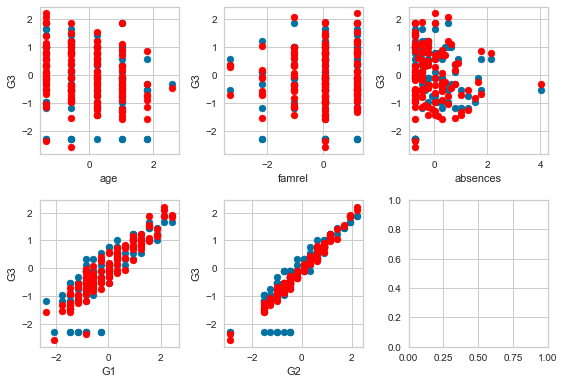

In [48]:
# Cria gráficos que demonstram as posições dos dados usando as variáveis indicadas no Yellowbrick, em uma matriz (2,3)
# acrescido do plot da predição
fig, ax = plt.subplots(2, 3)
ax[0,0].scatter(X_test.iloc[:,0],y_test);
ax[0,0].scatter(X_test.iloc[:,0],y_pred,color='red');
ax[0,0].set_xlabel('age');
ax[0,0].set_ylabel('G3');

ax[0,1].scatter(X_test.iloc[:,1],y_test);
ax[0,1].scatter(X_test.iloc[:,1],y_pred,color='red');
ax[0,1].set_xlabel('famrel');
ax[0,1].set_ylabel('G3');

ax[0,2].scatter(X_test.iloc[:,2],y_test);
ax[0,2].scatter(X_test.iloc[:,2],y_pred,color='red');
ax[0,2].set_xlabel('absences');
ax[0,2].set_ylabel('G3');

ax[1,0].scatter(X_test.iloc[:,3],y_test);
ax[1,0].scatter(X_test.iloc[:,3],y_pred,color='red');
ax[1,0].set_xlabel('G1');
ax[1,0].set_ylabel('G3');

ax[1,1].scatter(X_test.iloc[:,4],y_test);
ax[1,1].scatter(X_test.iloc[:,4],y_pred,color='red');
ax[1,1].set_xlabel('G2');
ax[1,1].set_ylabel('G3');

plt.tight_layout();

In [43]:
df_notas3.head()

,age,famrel,absences,G1,G2
0,1.023046,0.062194,0.036424,-1.782467,-1.254791
1,0.238380,1.178860,-0.213796,-1.782467,-1.520979
2,-1.330954,0.062194,0.536865,-1.179147,-0.722415
3,-1.330954,-1.054472,-0.464016,1.234133,0.874715
4,-0.546287,0.062194,-0.213796,-1.480807,-0.190038


#### Métricas do Modelo só com as colunas indicadas no Yellowbrick como importantes 

In [50]:
#avaliação da qualidade do modelo
score = notas_parcial.score(X_test, y_test)
print('Score:', score)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) #próx de 0, melhor
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #medida de dispersão

Score: 0.8091841086363154
Mean Absolute Error: 0.28939391364561756
Mean Squared Error: 0.20034539708798535
Root Mean Squared Error: 0.44759959460212356


# Conclusões?